In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import patheffects as pe

### Data

#### Global Data Parameters

In [3]:
IMAGE_SIZE = (244, 244)
TEST_SIZE = 1000
PLOT_DIRECTORY = 'Plots'

#### Data Generator Initialization

In [4]:
# Define ImageDataGenerator with custom augmentation parameters.
image_data_generator = ImageDataGenerator(horizontal_flip = True, 
    height_shift_range = 0.05, width_shift_range = 0.05, zoom_range = 0.2, 
    brightness_range = [0.9, 1.5], rescale = 1./255.)

# Initialize flow from training data directory.
train_flow = image_data_generator.flow_from_directory('PokemonData/Train', 
    target_size = IMAGE_SIZE, batch_size = 20)

# Set up flow from test data directory.
test_flow = image_data_generator.flow_from_directory('PokemonData/Test', 
    target_size = IMAGE_SIZE, batch_size = 5)

Found 3444 images belonging to 150 classes.
Found 3376 images belonging to 150 classes.


#### Validation Set Generation

In [5]:
# Initialize loop variables.
X_test = []
Y_test = []
test_size = TEST_SIZE

while len(X_test) < test_size:
    next_images, next_labels = test_flow.next()
    X_test.extend(next_images)
    Y_test.extend(next_labels)
    
# Cut off any extra unwanted images.
X_test = X_test[:test_size]
Y_test = Y_test[:test_size]
    
X_test = np.array(X_test)
Y_test = np.array(Y_test)

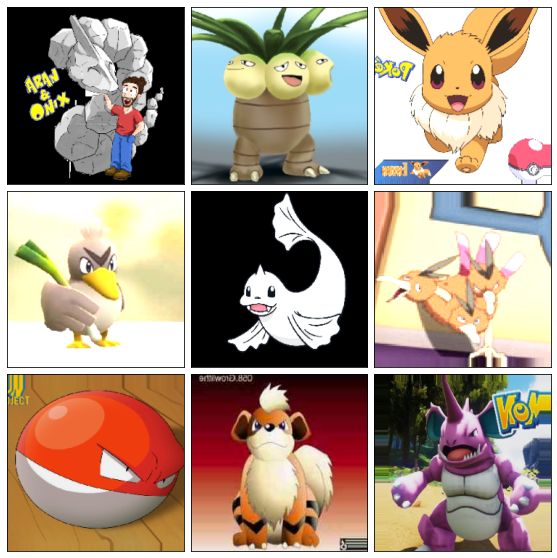

In [6]:
fig = plt.figure(1, (10, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

for ax, im in zip(grid, X_test):
    # Reverse normalization to get full pixel values.
    im = np.array(im * 255).astype('uint8')
    # Show image in grid cell.
    ax.imshow(im)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False,
        top = False, labelbottom = False, left = False, right = False,
        labelleft = False)

plt.show()
fig.savefig(PLOT_DIRECTORY + '/' + 'data_example.jpg')

### Scratch-Built Model

#### Model Structure

In [7]:
# Initialize model.
model = keras.models.Sequential()
# Convolutional Layers
model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu', 
    input_shape = (244, 244, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
    input_shape = (244, 244, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', 
    input_shape = (244, 244, 3)))
# Dense Layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation = 'relu'))
# Output Layer
model.add(keras.layers.Dense(150, activation = 'softmax'))

In [8]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-05),
    loss = keras.losses.CategoricalCrossentropy(), metrics = ['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 242, 242, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 207936)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

#### Training

In [10]:
scratch_model_history = model.fit(train_flow, epochs = 50, 
    validation_data = (X_test, Y_test))

Epoch 1/50
173/173 [==============================] - 102s 572ms/step - loss: 5.0103 - accuracy: 0.0073 - val_loss: 4.9954 - val_accuracy: 0.0070
Epoch 2/50
173/173 [==============================] - 101s 586ms/step - loss: 4.9877 - accuracy: 0.0096 - val_loss: 4.9704 - val_accuracy: 0.0110
Epoch 3/50
173/173 [==============================] - 100s 577ms/step - loss: 4.9639 - accuracy: 0.0136 - val_loss: 4.9408 - val_accuracy: 0.0150
Epoch 4/50
173/173 [==============================] - 99s 573ms/step - loss: 4.9340 - accuracy: 0.0186 - val_loss: 4.9131 - val_accuracy: 0.0190
Epoch 5/50
173/173 [==============================] - 100s 577ms/step - loss: 4.8997 - accuracy: 0.0256 - val_loss: 4.8877 - val_accuracy: 0.0200
Epoch 6/50
173/173 [==============================] - 107s 616ms/step - loss: 4.8622 - accuracy: 0.0276 - val_loss: 4.8603 - val_accuracy: 0.0260
Epoch 7/50
173/173 [==============================] - 99s 571ms/step - loss: 4.8265 - accuracy: 0.0380 - val_loss: 4.8264 - v

#### Results

In [38]:
def plot_training_history(history, save_name, metric = 'loss'):
    """
    Plot training and validation metrics over epochs.
    
    Args:
        history: Return value of a keras model's fit method.
        save_name: Name to save the generated plot under (including file ext)
        metric: All lowercase name of the metric you wish to plot.
         - default: 'loss'
    """
    # Initialize plot.
    fig = plt.figure(2, (7, 4))
    ax = fig.add_axes([0, 0, 1, 1])
    # Initialize empty list to save each line for the legend.
    lines = []
    
    # Expand history properties for brevity.
    params = history.params
    metrics = history.history
    # Find minimum validation loss.
    min_val_loss = np.array(metrics['val_' + metric]).min()
    # Find which epoch the minimum validation loss was reached.
    min_val_loss_bool_idx = np.array(metrics['val_' + metric]) == min_val_loss
    min_val_loss_x = np.arange(params['epochs'])[min_val_loss_bool_idx]
    
    # Plot Content
    lines.append(ax.plot(metrics[metric]))
    lines.append(ax.plot(metrics['val_' + metric]))
    ax.scatter(min_val_loss_x, min_val_loss, color = 'green', zorder = 3)

    # Limits
    ax.set_xlim(0, params['epochs'] - 1)

    # Labels
    ax.set_title('Loss Over Epochs (Lower Is Better)')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric.title())
    txt = ax.text(min_val_loss_x - params['epochs'] / 60, min_val_loss, 
        'Lowest Validation Loss - {:.2f}'.format(min_val_loss), ha = 'right')
    txt.set_path_effects([pe.withStroke(linewidth = 7, foreground = 'w')])

    # Legend
    ax.legend(labels = ['Training Loss', 'Validation Loss']);
    
    fig.savefig(PLOT_DIRECTORY + '/' + save_name)

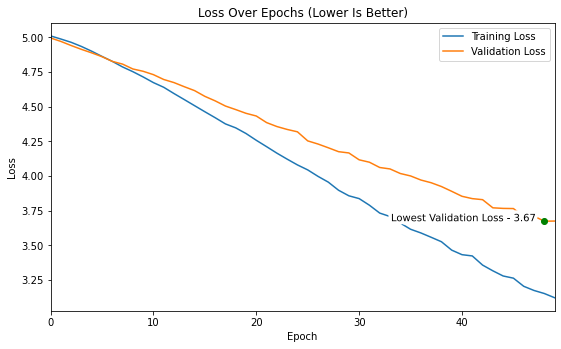

In [39]:
plot_training_history(scratch_model_history, 'scratch_model_loss.jpg')

### Transfer Learning

In [13]:
def build_model(application, output_count = 2, input_shape = (244, 244, 3), 
    dense_count = 128, learning_rate = 1e-05, l2_factor = 1e-05):
    '''
    Build a 2D convolutional neural network for transfer learning using a base
    keras application. 

    Args:
        application: Keras application to use as base model.
        output_count: Amount of classes in the model's output.
         - default: 2
        input_shape: Shape of the image data the network will be predicting on.
         - default: (224, 224, 3)
        dense_count: Amount of neurons in the dense layer between the last
        convolutional layer and the output layer.
         - default: 128
        learning_rate: Learning rate for Adam optimizer.
         - default: 1e-5
        l2_factor: Factor for l2 regularizer.
         - default: 1e-2

    Returns:
        model: Convolutional neural network made using provided specifications.
    '''
    # Model property shotrcuts.
    l2 = tf.keras.regularizers.l2(l2_factor)
    adam = tf.keras.optimizers.Adam(learning_rate)
    # Initalize application.
    base_model = application(weights = 'imagenet', include_top = False,
        input_shape = input_shape)
    base_model.trainable = False
    # Initialize model.
    model = tf.keras.models.Sequential()
    # Base
    model.add(base_model)
    # Dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation = 'relu', 
        kernel_regularizer = l2, bias_regularizer = l2, 
        activity_regularizer = l2))
    # Output layer
    model.add(tf.keras.layers.Dense(output_count, activation = 'softmax'))
    
    model.compile(optimizer = adam, loss = 'categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy()])

    print(model.summary())

    return model

#### VGG16

In [14]:
vgg16_model = build_model(tf.keras.applications.VGG16, output_count = 150)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_3 (Dense)              (None, 150)               19350     
Total params: 17,945,430
Trainable params: 3,230,742
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [15]:
vgg16_model_history = vgg16_model.fit(train_flow, epochs = 50, 
    validation_data = (X_test, Y_test))

Epoch 1/50
173/173 [==============================] - 107s 591ms/step - loss: 5.0487 - categorical_accuracy: 0.0084 - val_loss: 4.9658 - val_categorical_accuracy: 0.0240
Epoch 2/50
173/173 [==============================] - 94s 540ms/step - loss: 4.9329 - categorical_accuracy: 0.0192 - val_loss: 4.8922 - val_categorical_accuracy: 0.0280
Epoch 3/50
173/173 [==============================] - 95s 546ms/step - loss: 4.8335 - categorical_accuracy: 0.0404 - val_loss: 4.7915 - val_categorical_accuracy: 0.0590
Epoch 4/50
173/173 [==============================] - 93s 539ms/step - loss: 4.7060 - categorical_accuracy: 0.0743 - val_loss: 4.6574 - val_categorical_accuracy: 0.0930
Epoch 5/50
173/173 [==============================] - 94s 543ms/step - loss: 4.5508 - categorical_accuracy: 0.1263 - val_loss: 4.5316 - val_categorical_accuracy: 0.1490
Epoch 6/50
173/173 [==============================] - 99s 572ms/step - loss: 4.3801 - categorical_accuracy: 0.1762 - val_loss: 4.3889 - val_categorical_ac

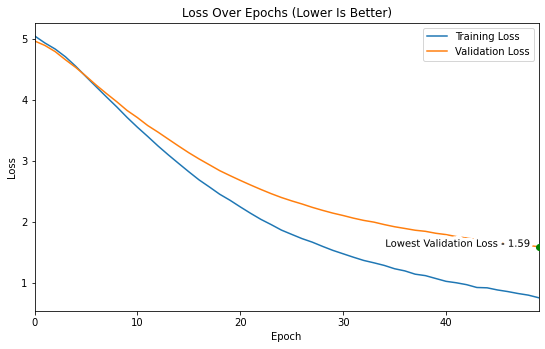

In [40]:
plot_training_history(vgg16_model_history, 'vgg16_model_loss.jpg')

#### Xception

In [17]:
xception_model = build_model(tf.keras.applications.Xception, output_count = 150)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_5 (Dense)              (None, 150)               19350     
Total params: 37,658,174
Trainable params: 16,796,694
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [18]:
xception_model_history = xception_model.fit(train_flow, epochs = 50, 
    validation_data = (X_test, Y_test))

Epoch 1/50
173/173 [==============================] - 88s 490ms/step - loss: 4.8615 - categorical_accuracy: 0.0453 - val_loss: 4.5937 - val_categorical_accuracy: 0.0980
Epoch 2/50
173/173 [==============================] - 83s 477ms/step - loss: 4.1230 - categorical_accuracy: 0.1969 - val_loss: 3.9884 - val_categorical_accuracy: 0.2140
Epoch 3/50
173/173 [==============================] - 83s 477ms/step - loss: 3.3391 - categorical_accuracy: 0.3812 - val_loss: 3.5088 - val_categorical_accuracy: 0.3140
Epoch 4/50
173/173 [==============================] - 83s 477ms/step - loss: 2.7323 - categorical_accuracy: 0.5163 - val_loss: 3.1730 - val_categorical_accuracy: 0.3790
Epoch 5/50
173/173 [==============================] - 83s 477ms/step - loss: 2.2815 - categorical_accuracy: 0.6266 - val_loss: 2.9196 - val_categorical_accuracy: 0.4280
Epoch 6/50
173/173 [==============================] - 82s 476ms/step - loss: 1.9229 - categorical_accuracy: 0.6957 - val_loss: 2.7195 - val_categorical_acc

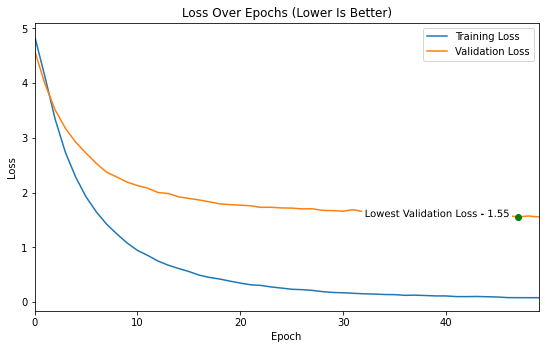

In [41]:
plot_training_history(xception_model_history, 'xception_model_loss.jpg')

#### ResNet50

In [20]:
resnet50_model = build_model(tf.keras.applications.ResNet50, output_count = 150)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_7 (Dense)              (None, 150)               19350     
Total params: 40,384,406
Trainable params: 16,796,694
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [21]:
resnet50_model_history = resnet50_model.fit(train_flow, epochs = 50, 
    validation_data = (X_test, Y_test))

Epoch 1/50
173/173 [==============================] - 95s 527ms/step - loss: 5.0486 - categorical_accuracy: 0.0044 - val_loss: 5.0185 - val_categorical_accuracy: 0.0040
Epoch 2/50
173/173 [==============================] - 86s 494ms/step - loss: 5.0139 - categorical_accuracy: 0.0070 - val_loss: 5.0124 - val_categorical_accuracy: 0.0080
Epoch 3/50
173/173 [==============================] - 88s 511ms/step - loss: 5.0095 - categorical_accuracy: 0.0064 - val_loss: 5.0094 - val_categorical_accuracy: 0.0070
Epoch 4/50
173/173 [==============================] - 87s 503ms/step - loss: 5.0076 - categorical_accuracy: 0.0081 - val_loss: 5.0085 - val_categorical_accuracy: 0.0080
Epoch 5/50
173/173 [==============================] - 88s 510ms/step - loss: 5.0063 - categorical_accuracy: 0.0090 - val_loss: 5.0048 - val_categorical_accuracy: 0.0090
Epoch 6/50
173/173 [==============================] - 85s 489ms/step - loss: 5.0025 - categorical_accuracy: 0.0096 - val_loss: 4.9969 - val_categorical_acc

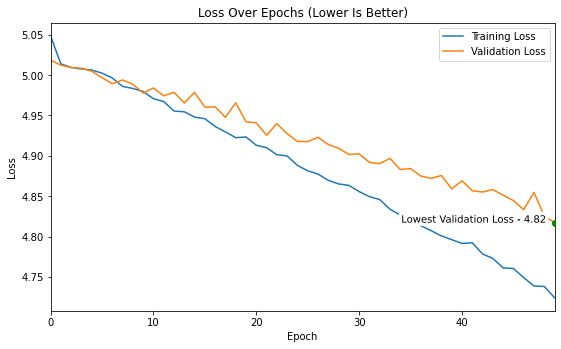

In [42]:
plot_training_history(resnet50_model_history, 'resnet50_model_loss.jpg')

In [43]:
model.save('Models/scratch_model')
vgg16_model.save('Models/vgg16_model')
xception_model.save('Models/xception_model')
resnet50_model.save('Models/resnet50_model')

INFO:tensorflow:Assets written to: Models/scratch_model\assets
INFO:tensorflow:Assets written to: Models/vgg16_model\assets
INFO:tensorflow:Assets written to: Models/xception_model\assets


C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: Models/resnet50_model\assets


C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


### Who's That Pokémon?! Model Showdown

In [ ]:
import os

In [ ]:
colors = [plt.imread(image_file) for image_file in os.listdir('PokemonData/Game Sprites Color')]
silhouettes = [plt.imread(image_file) for image_file in os.listdir('PokemonData/Game Sprites Silhouette')]